In [1]:
import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib import colors as mcolors

import package_DBR
import package_LAB

from importlib import reload
package_DBR = reload(package_DBR)
package_LAB = reload(package_LAB)

from package_DBR import *
from package_LAB import *







from IPython.display import display, clear_output

from datetime import datetime
import tclab
import time

import os

# LL_RT()

In [3]:
help(LL_RT)

Help on function LL_RT in module package_LAB:

LL_RT(MV, Kp, Ts, Tle, Tla, PV, PVInit=0, method='EBD')
    The function "LL_RT" needs to be included in a "for or while loop".
    
    :MV: input vector
    :Kp: process gain
    :Tla: lag time constant [s]
    :Ts: sampling period [s]
    :Tle: lead time constant [s]
    :PV: output vector
    :PVInit: (optional: default value is 0)
    :method: discretisation method (optional: default value is 'EBD')
        EBD: Euler Backward difference
        EFD: Euler Forward difference
        TRAP: Trapezoïdal method
    
    The function "LL_RT" appends a value to the output vector "PV".
    The appended value is obtained from a recurrent equation that depends on the discretisation method.



# PID_RT()

In [4]:
help(PID_RT)

Help on function PID_RT in module package_LAB:

PID_RT(SP, PV, Man, MVMan, MVFF, Kc, Ti, Td, alpha, Ts, MVmin, MVmax, MV, MVP, MVI, MVD, E, ManFF=False, PVinit=0, method='EBD-EBD')
    SP = setpoint vector
    PV = process value vector
    Man = manual controller mode vector : bool
    MVMan = Manual value for MV vector
    MVFF = feedforward vector
    Kc = controller gain
    Ti= integral time constant
    Td = derivative time constant
    alpha = Tfd = alpha*Td = where Tfd is derivative filter time constant
    
    MVMin = min value for MV
    MVMax = max value for MV
    
    MV = Maniplated value vector
    MVP = proportional part of MV vector
    MVI =  integral part of MV vector
    MVD = derivative part of MV vector
    E = control error vector
    
    ManFF = activated FF in manuel mode
    PVInit = initial value of PV
    Method : discreditisation value for PV
        EBD-EBD: Euler Backward difference
        TRAP-TRAP: Trapezoïdal method
    
    The function PID_RT appen

# Controller and FF parameters

In [11]:
TSim = 2500
Ts = 1
N = int(TSim/Ts) + 1
MV0 = 50
DV0 = 50
PV0 = 62.2 
# Parameters MV
Kp = 0.48305278277951064
T1p = 159.84828454194727
T2p = 11.44559902845228
thetap = 4.009584499836511
# Parameters DV (test changer les valeurs)
Kd = 0.4307501025499605
T1d = 157.77345895847023
T2d = 53.272586489684905
thetad = 12.645547269207029
# Parameters PID controller
gamma = 0.85 # tester avec d'autres valeurs
Kc, Ti, Td = IMCTuning(Kp,T1p,T2p,thetap,gamma,'SOPDT')
print("Kc : ",Kc,", Ti : ", Ti,", Td : ", Td)
alpha = 1
MVMin = 0 
MVMax = 100

Kc :  2.53506850132495 , Ti :  171.29388357039954 , Td :  10.680821358698136


# Input signals

In [5]:
settings = 'FF' 


if settings == 'Man':
    #  OLP, no FF
    ManPath = {0: True, 500: False, TSim: False}
    MVManPath = {0: MV0, TSim: MV0}
    SPPath = {0: PV0, 1200: PV0-10, TSim: PV0-10} 
    DVPath = {0: DV0, 1800: DV0, TSim: DV0}
    ManFF = False
    Title_loop = "Open-loop"
    Title_FF = "no feedforward"
    
elif settings == 'ManFF':
    # OLP, FF
    ManPath = {0: False, 400: True,1500:False, TSim: False}
    MVManPath = {0: 100,750:20,1000:500, TSim: MV0}
    SPPath = {0: PV0, 1200: PV0-10, TSim: PV0-10} 
    DVPath = {0: DV0, 1800: DV0, TSim: DV0}
    ManFF = True
    Title_loop = "Open-loop"
    Title_FF = "feedforward"

elif settings == 'FF':
    # FF, CLP
    ManPath = {0: True, 500: False, TSim: False}
    MVManPath = {0: MV0, TSim: MV0}
    SPPath = {0: PV0, 1200: PV0-10, TSim: PV0-10}  
    DVPath = {0: DV0, 1800: DV0+10, TSim: DV0}
    ManFF = True
    Title_loop = "Closed-loop"
    Title_FF = "feedforward"
    
else:
    # no FF, CLP
    ManPath = {0: True, 500: False, TSim: False}
    MVManPath = {0: MV0, TSim: MV0} 
    SPPath = {0: PV0, 1200: PV0-10, TSim: PV0-10}  
    DVPath = {0: DV0, 1800: DV0+10, TSim: DV0}
    ManFF = False
    Title_loop = "Closed-loop"
    Title_FF = "no feedforward"


# Real-time control and visualisation of the signals

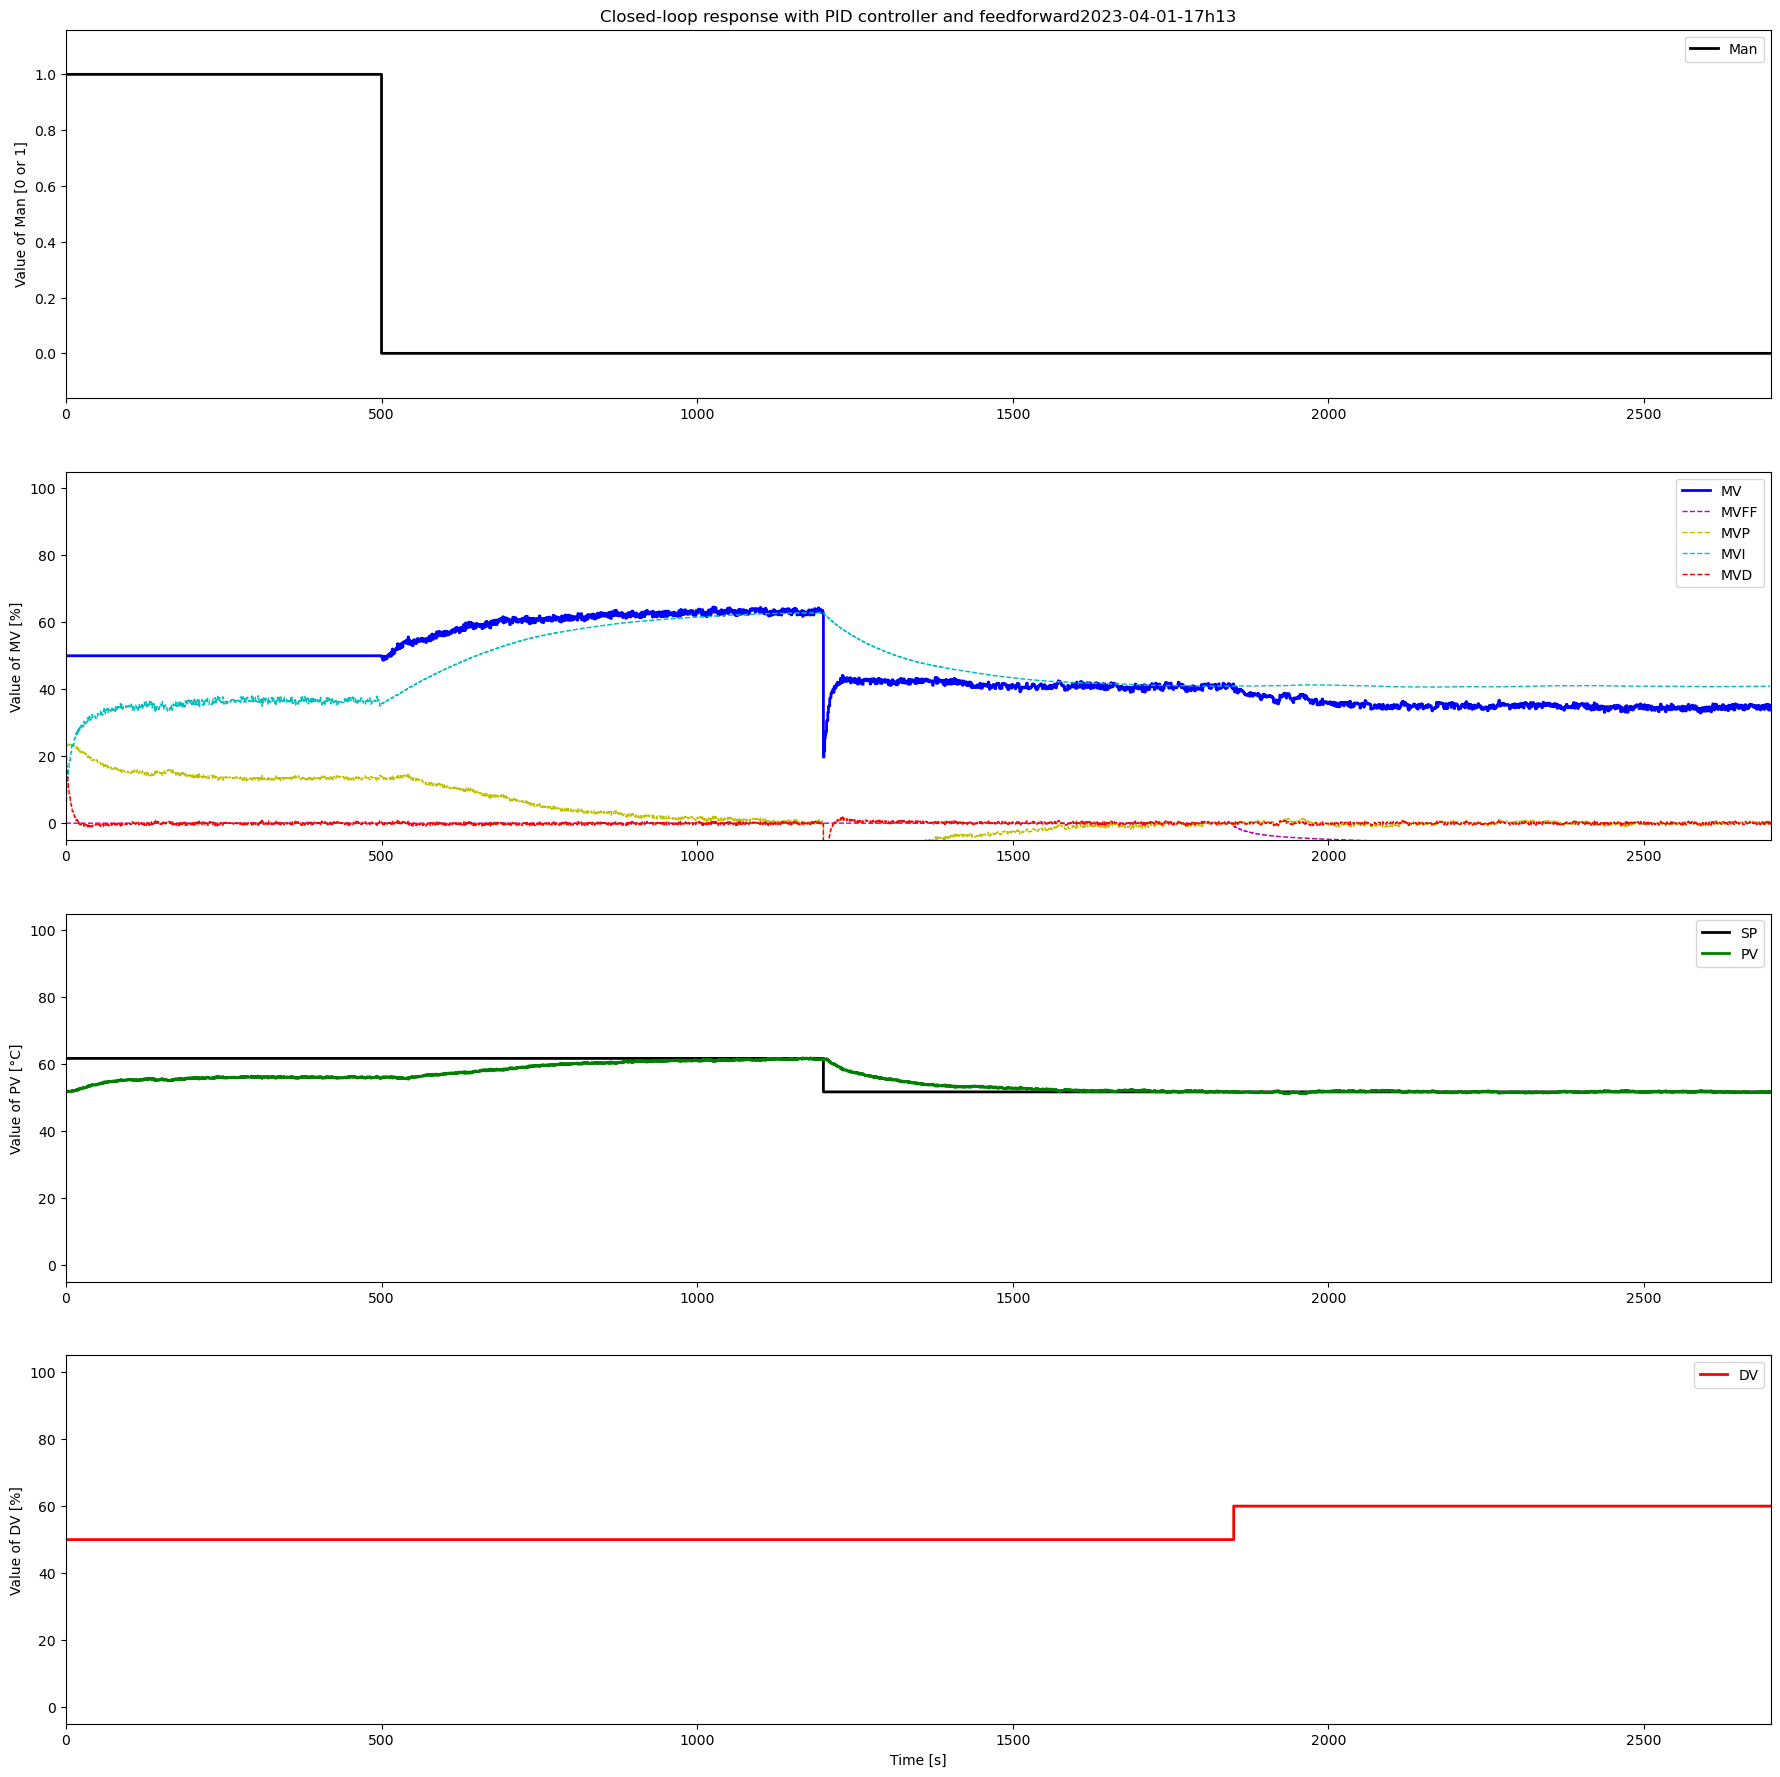

TCLab disconnected successfully.


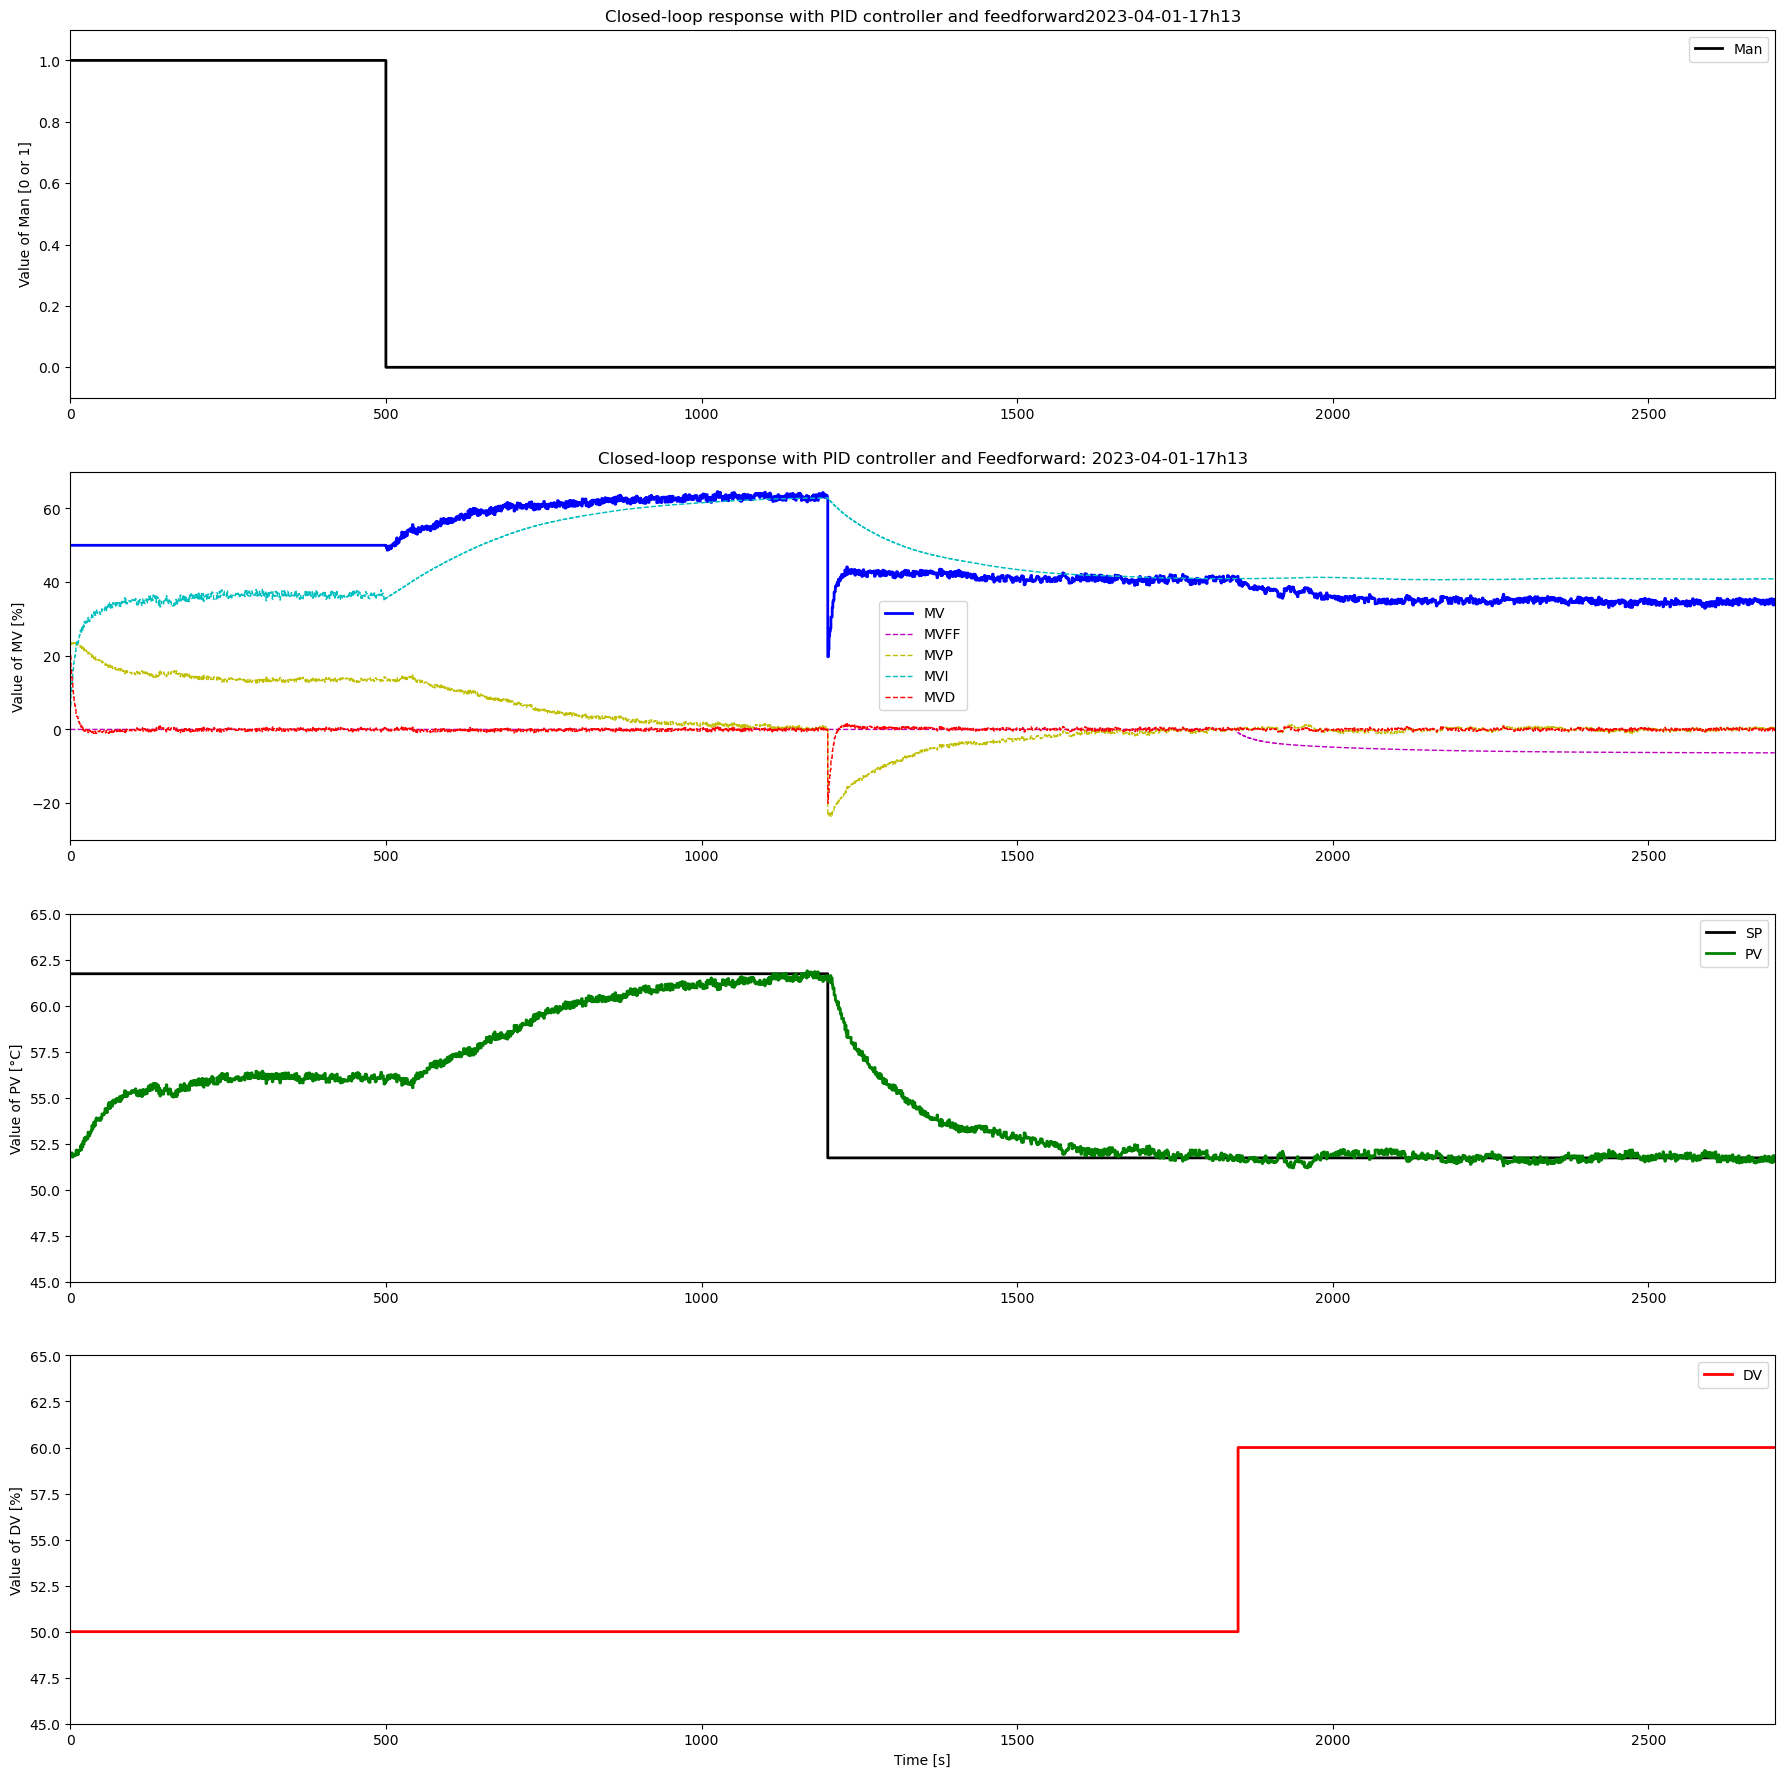

In [ ]:
t = []
SP = []
MV = []
Man = []
MVMan = []
MVFF = []
MVP = []
MVI = []
MVD = []
DV = []
PV = []
E = []

MVFFDelay = []
MVFFLL1 = []

lab = tclab.TCLab()

now = datetime.now()
date_time = now.strftime("%Y-%m-%d-%Hh%M")


fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1)
fig.set_figheight(22)
fig.set_figwidth(22)

l1, = ax1.step([0,TSim],[-0.1,1.1],'k-',linewidth=2,label="Man",where='post')
ax1.set_ylabel('Value of Man [0 or 1]')
ax1.set_title('Closed-loop response with PID controller and feedforward' + date_time)
ax1.legend(loc='best')

l2, = ax2.step([0,TSim],[0,100],'b-',linewidth=2,label="MV",where='post')
l9, = ax2.step([0,TSim],[0,100],'--m',linewidth=1,label="MVFF",where='post')
l3, = ax2.step([0,TSim],[0,100],'--y',linewidth=1,label="MVP",where='post')
l4, = ax2.step([0,TSim],[0,100],'--c',linewidth=1,label="MVI",where='post')
l5, = ax2.step([0,TSim],[0,100],'--r',linewidth=1,label="MVD",where='post')
ax2.set_ylabel("Value of MV [%]")
ax2.legend(loc='best')

l6, = ax3.step([0,TSim],[0,100],'k-',linewidth=2,label="SP",where='post')
l7, = ax3.step([0,TSim],[0,100],'g-',linewidth=2,label="PV",where='post')
ax3.set_ylabel("Value of PV [°C]")
ax3.legend(loc='best')

l8, = ax4.step([0,TSim],[0,100],'r-',linewidth=2,label="DV",where='post')
ax4.set_xlabel("Time [s]")
ax4.set_ylabel("Value of DV [%]")
ax4.legend(loc='best')


for i in range(0,N):
    t.append(i*Ts)
    
    # Process Value
    PV.append(lab.T1)
    
    # Input signals SP and DV
    SelectPath_RT(SPPath,t,SP)
    SelectPath_RT(DVPath,t,DV)
    
    # Apply DV
    lab.Q2(DV[-1])
    
    # Feedforward
    Delay_RT(DV - DV0*np.ones_like(DV),np.max([thetad-thetap,0]),Ts,MVFFDelay)
    LeadLag_RT(MVFFDelay,-Kd/Kp,T1p,T1d,Ts,MVFFLL1)   # passe à travers le 1er leadlag, le gain est la
    if ActivateFF:
        LeadLag_RT(MVFFLL1,1,T2p,T2d,Ts,MVFF)         # passe à travaers le 2e leadlag
    else:
        LeadLag_RT(MVFFLL1,0,T2p,T2d,Ts,MVFF)
        
    # PID 
    SelectPath_RT(ManPath,t,Man)
    SelectPath_RT(MVManPath,t,MVMan)
    PID_RT(SP,PV,Man,MVMan,MVFF,Kc,Ti,Td,alpha,Ts,MVMin,MVMax,MV,MVP,MVI,MVD,E,ManFF)
    
    # MV
    lab.Q1(MV[-1])
    
    # Ts
    time.sleep(Ts)    
    l1.set_data(t,Man)    
    l2.set_data(t,MV)
    l3.set_data(t,MVP)
    l4.set_data(t,MVI)
    l5.set_data(t,MVD)    
    l6.set_data(t,SP)
    l7.set_data(t,PV)   
    l8.set_data(t,DV)
    l9.set_data(t,MVFF)
    
    clear_output(wait=True)
    
    # Remove if increasing x-axis lenght is not desired
    ax1.set_xlim(0, t[-1]+1)
    ax2.set_xlim(0, t[-1]+1)
    ax3.set_xlim(0, t[-1]+1)
    ax4.set_xlim(0, t[-1]+1)
    
    display(fig)
    
lab.close() # Disconnect from TCLab

# Save plot
ax1.set_ylim(-0.1,1.1)
ax2.set_title('Closed-loop response with PID controller and Feedforward: ' + date_time)
ax2.set_ylim(myRound(np.min((np.min(MV), np.min(MVP), np.min(MVI), np.min(MVD), np.min(MVFF))),5)-5, myRound(np.max((np.max(MV), np.max(MVP), np.max(MVI), np.max(MVD), np.max(MVFF))),5)+5)
ax3.set_ylim(myRound(np.min((np.min(PV),np.min(SP))),5)-5, myRound(np.max((np.max(PV),np.max(SP))),5)+5)
ax4.set_ylim(myRound(np.min(DV),5)-5,myRound(np.max(DV),5)+5)

nameFile = 'Plots/Closed_loop_experiment3_with_PID_and_FF_' + scenario
plt.savefig(nameFile + '.png',transparent=True)            
plt.savefig(nameFile + '.pdf',transparent=True)            

# Save data
t = np.array(t)
MV = np.array(MV)
MVP = np.array(MVP)             
MVI = np.array(MVI)             
MVD = np.array(MVD)    
MVFF = np.array(MVFF) 
SP = np.array(SP) 
PV = np.array(PV) 
DV = np.array(DV)   
Man = np.array(Man) 
my_data = np.vstack((t.T,MV.T,MVP.T,MVI.T,MVD.T,MVFF.T,SP.T,PV.T,DV.T,Man.T))
my_data = my_data.T
nameFile = 'Data/Experiment_'+scenario+'.txt'
np.savetxt(nameFile,my_data,delimiter=',',header='t,MV,MVP,MVI,MVD,MVFF,SP,PV,DV,Man',comments='')